На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

План 3 недели:

Часть 1. Построение признаков

Часть 2. Визуальный анализ данных

Часть 3. Дальнейшее построение признаков

Часть 4. Проверка построенных признаков

В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":

- Задача визуализации
- Визуализация данных в sklearn

Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой pip install seaborn), будет полезно обращаться к документациям Matplotlib и Seaborn, а также к примерам визуализации, описанным на StackOverflow.

# Часть 1. Построение признаков

In [38]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [39]:
PATH_TO_DATA = 'capstone_user_identification'

Создайте на основе функций prepare_train_set и prepare_sparse_train_set_window новую – prepare_train_set_with_fe, (от "feature engineering"), создайте следующие признаки:

session_timespan – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)

#unique_sites – число уникальных сайтов в сессии

start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)

day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция prepare_train_set), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: site1, ... site10, session_timespan, #unique_sites, start_hour, day_of_week и user_id (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    sessions_list = []
    with open(site_freq_path, 'rb') as f:
        freq_dict = pickle.load(f)
    users_files = sorted(glob(os.path.join(path_to_csv_files, 'user[0-9][0-9][0-9][0-9].csv')))
    for user in tqdm_notebook(users_files):
        user_data = pd.read_csv(user)
        site_list = user_data.site.values
        timestamp_list = [pd.to_datetime(timestamp) for timestamp 
                          in user_data.timestamp.values]
        session = {}  # Current session
        for i in range(0, len(site_list), window_size):
            site_window = site_list[i: i + session_length]
            for j, site in enumerate(site_window):
                session['site{}'.format(j + 1)] = freq_dict[site][0]
            unique_sites = np.unique(site_window).shape[0]
            time_window = timestamp_list[i: i + session_length]
            for k, timestamp in enumerate(time_window[:-1]):
                session['time_diff{}'.format(k + 1)] = (time_window[k + 1] - timestamp).total_seconds()
            session['target'] = int(user.strip('.csv')[-4:])
            session['session_timespan'] = (time_window[-1] - time_window[0]).total_seconds()
            session['#unique_sites'] = unique_sites
            session['start_hour'] = time_window[0].hour
            session['day_of_week'] = time_window[0].weekday()
            sessions_list.append(session)
            session = {}
    dframe = pd.DataFrame(sessions_list, columns=feature_names).fillna(0).astype(int)
    return dframe

Проверим функцию на игрушечном примере.

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# Example of the DataFrame
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [6]:
# The resulting DataFrame
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


Примените функцию prepare_train_set_with_fe к данным по 10 пользователям, укажите session_length=10.

In [7]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 12.1 s


In [8]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


Примените функцию prepare_train_set_with_fe к данным по 150 пользователям, укажите session_length=10.

In [9]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

  0%|          | 0/150 [00:00<?, ?it/s]

Wall time: 1min 57s


Сохраните в pickle-файлы признаки session_timespan, #unique_sites, start_hour и day_of_week для 10 и 150 пользователей.

In [10]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

# Часть 2. Визуальный анализ данных

## Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.

In [12]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [13]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

1. Постройте гистограмму распределения длины сессии в секундах (session_timespan). Ограничьте по x значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета darkviolet, подпишите оси по-русски.

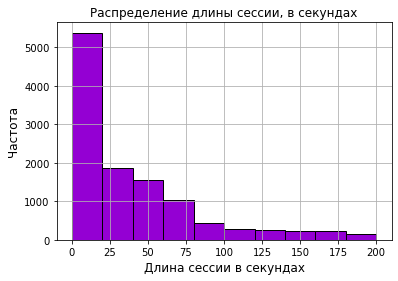

In [40]:
train_data_10users['session_timespan'].hist(range=(0, 200), color='darkviolet', edgecolor='black')
plt.xlabel('Длина сессии в секундах', fontsize='large')
plt.ylabel('Частота', fontsize='large')
plt.title('Распределение длины сессии, в секундах', fontsize='large')
plt.show()

2. Постройте гистограмму распределения числа уникальных сайтов в сессии (#unique_sites). Сделайте гистограмму цвета aqua, подпишите оси по-русски.

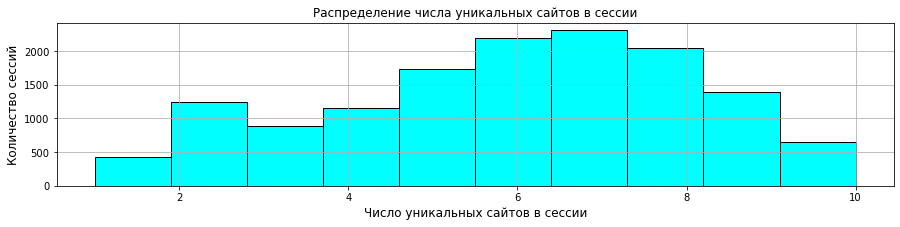

In [41]:
train_data_10users['#unique_sites'].hist(range=(1, 10), bins=10, 
                                         color='aqua', edgecolor='black', figsize = (15, 3))
plt.xlabel('Число уникальных сайтов в сессии', fontsize='large')
plt.ylabel('Количество сессий', fontsize='large')
plt.title('Распределение числа уникальных сайтов в сессии', fontsize='large')
plt.show()

3. Постройте гистограммы распределения числа уникальных сайтов в сессии (#unique_sites) для каждого из 10 пользователей по отдельности. Используйте subplots, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (color_dic). Подпишите оси по-русски в каждой из 10 гистограмм.

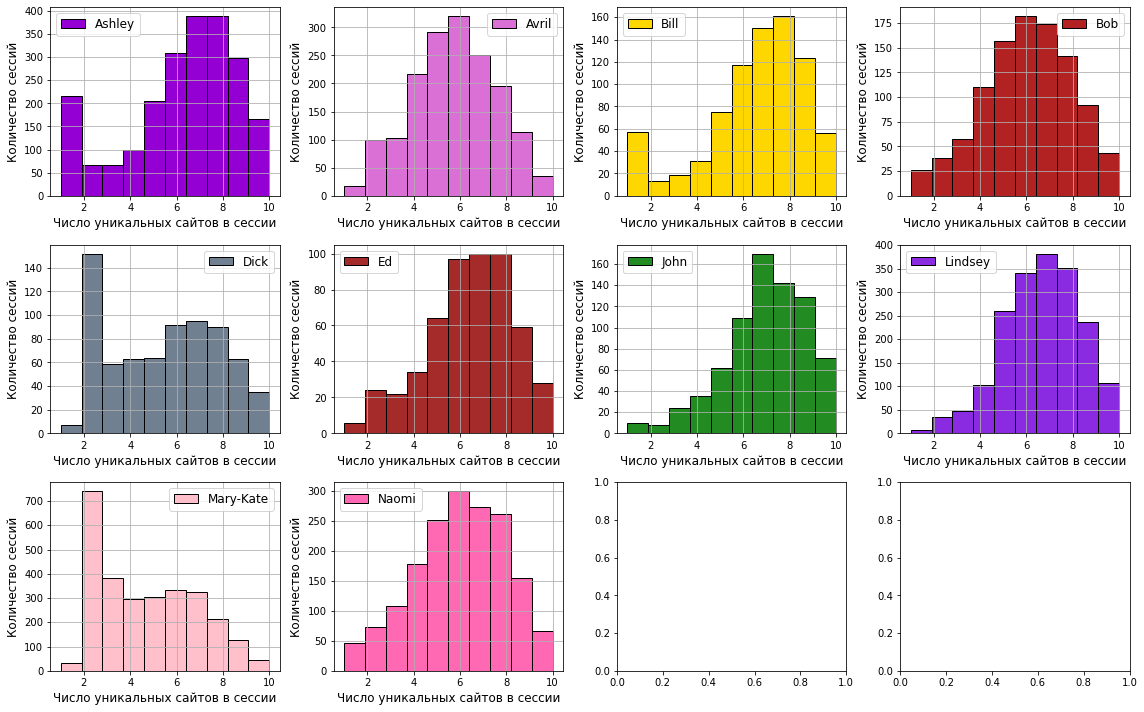

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    sub_df['#unique_sites'].hist(range=(1, 10), bins=10, color=color_dic[user], 
                                 ax=axes[idx//4, idx%4], edgecolor='black')
    axes[idx//4, idx%4].set_xlabel('Число уникальных сайтов в сессии', fontsize='large')
    axes[idx//4, idx%4].set_ylabel('Количество сессий', fontsize='large')
    axes[idx//4, idx%4].legend([user], fontsize='large')
plt.tight_layout()

4. Постройте гистограмму распределения часа начала сессии (start_hour). Сделайте гистограмму цвета darkgreen, подпишите оси по-русски.

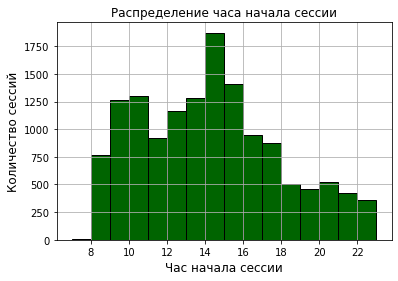

In [43]:
bins = range(train_data_10users.start_hour.min(), 
             train_data_10users.start_hour.max() + 1)
train_data_10users['start_hour'].hist(bins=bins, color='darkgreen', 
                                      edgecolor='black')
plt.xlabel('Час начала сессии', fontsize='large')
plt.ylabel('Количество сессий', fontsize='large')
plt.title('Распределение часа начала сессии', fontsize='large')
plt.show()

5. Постройте гистограммы распределения часа начала сессии (start_hour) для каждого из 10 пользователей по отдельности. Используйте subplots, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (color_dic). Подпишите оси по-русски в каждой из 10 гистограмм.

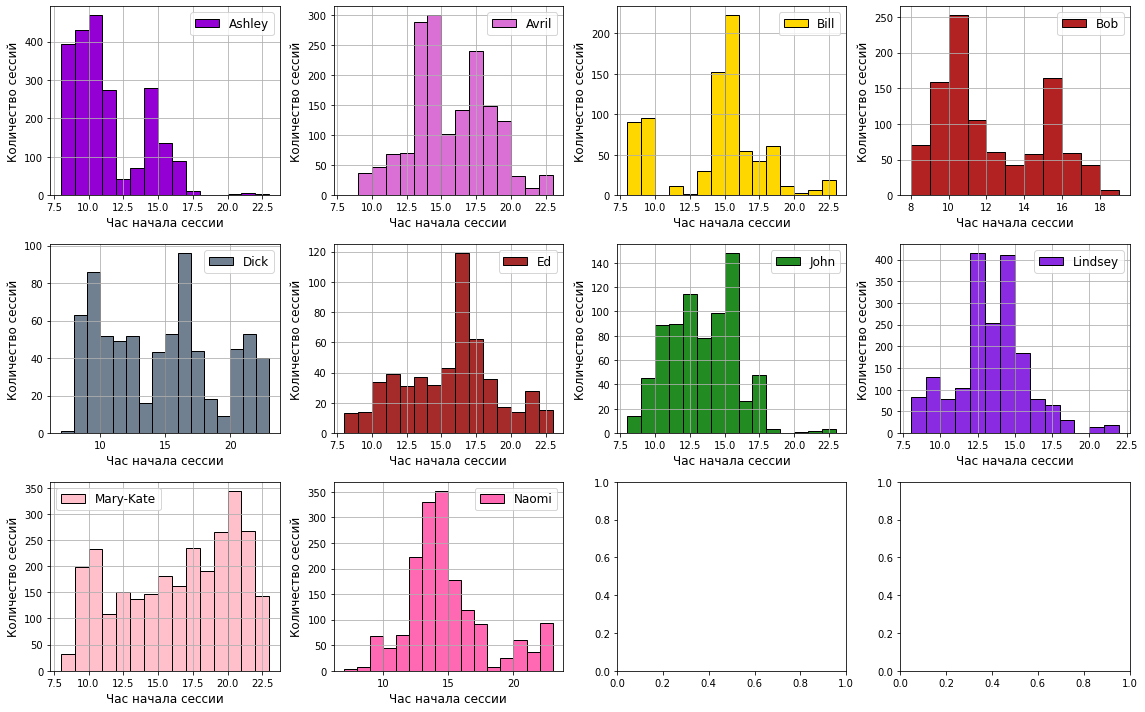

In [44]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    bins = range(sub_df.start_hour.min(), 
                 sub_df.start_hour.max() + 1)
    sub_df['start_hour'].hist(color=color_dic[user], ax=axes[idx//4, idx%4], 
                              bins=bins, edgecolor='black')
    axes[idx//4, idx%4].set_xlabel('Час начала сессии', fontsize='large')
    axes[idx//4, idx%4].set_ylabel('Количество сессий', fontsize='large')
    axes[idx//4, idx%4].legend([user], fontsize='large')
plt.tight_layout()

6. Постройте гистограмму распределения дня недели, в который началась сессия (day_of_week). Сделайте гистограмму цвета sienna, подпишите оси по-русски.

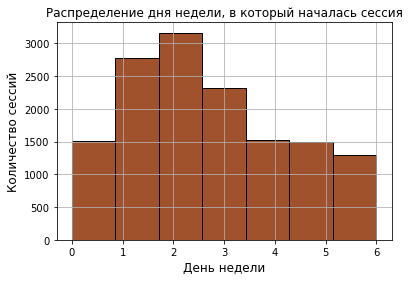

In [45]:
train_data_10users['day_of_week'].hist(color='sienna', bins=7, 
                                       range=(0, 6), edgecolor='black')
plt.xlabel('День недели', fontsize='large')
plt.ylabel('Количество сессий', fontsize='large')
plt.title('Распределение дня недели, в который началась сессия', fontsize='large')
plt.show()

7. Постройте гистограммы распределения дня недели, в который началась сессия (day_of_week) для каждого из 10 пользователей по отдельности. Используйте subplots, чтоб разместить все 10 картинок на одной большой. Измените метки по оси X на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод set_xticklabels. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (color_dic). Подпишите по-русски название каждой из 10 гистограмм.

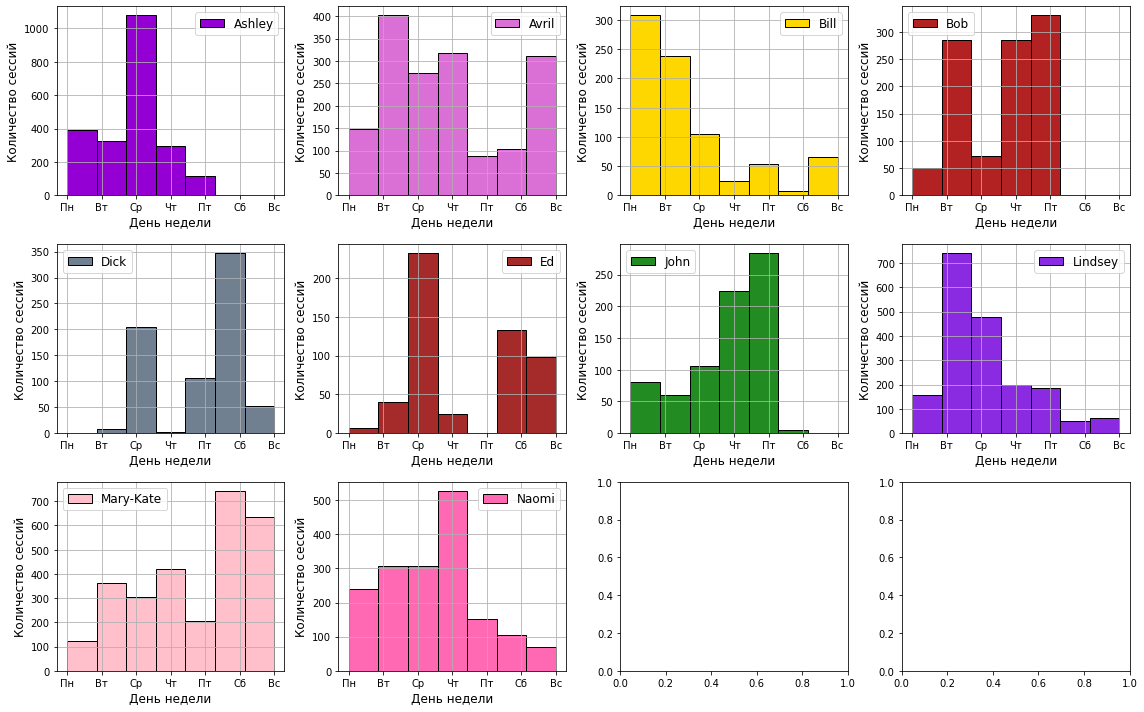

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    sub_df['day_of_week'].hist(color=color_dic[user], ax=axes[idx//4, idx%4], 
                               bins=7, range=(0, 6), edgecolor='black')
    axes[idx//4, idx%4].set_xlabel('День недели', fontsize='large')
    axes[idx//4, idx%4].set_ylabel('Количество сессий', fontsize='large')
    axes[idx//4, idx%4].set_xticks(np.arange(7))
    axes[idx//4, idx%4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    axes[idx//4, idx%4].legend([user], fontsize='large')
plt.tight_layout()

# 8. Сделайте выводы про каждого пользователя по построенным графикам.

По построенным графикам можно сделать некоторые выводы:

## Ashley
Посещает разные сайты; пользуется интернетом утром и днем; имеется выраженный пик активности в утренние часы; выходит в интернет в рабочие дни.

## Avril
Посещает по большей части разные сайты; пользуется интернетов днем и ближе к вечеру; имеются два выраженных пика активности (13:00-14:00, 17:00); выходит в интернет на протяжении всей недели, но наиболее активно во вторник, среду, четверг и воскресенье.

## Bill
Посещает разные сайты; пользуется интернетом утром и днем; имеется выраженный пик активности в дневные часы; выходит в интернет на протяжении всей недели, но наиболее активно в понедельник и вторник.

## Bob
Посещает по большей части разные сайты; пользуется интернетом утром и днем; имеются два выраженных пика активности (10:00, 15:00); выходит в интернет в рабочие дни, наиболее активно во вторник, четверг и пятницу.

## Dick
У данного пользователя имеется большое количество сессий с двумя уникальными сайтами, однако и имеется умеренное количество сессий с большим числом уникальных сайтов; пользуется интернетом на протяжении всего дня; имеются два выраженных пика активности (09:00, 16:00); выходит в интернет во все дни, кроме понедельника, наиболее активно в среду и субботу.

## Ed
Посещает разные сайты; пользуется интернетом на протяжении всего дня, наиболее активно в дневное время; имеется выраженный пик активности (16:00); выходит в интернет на протяжении всей недели, кроме пятницы, наиболее активно в среду, субботу и воскресенье.

## John
Посещает разные сайты; пользуется интернетом по большей части в дневное время; имеется выраженный пик активности (15:00); выходит в интернет в рабочие дни, наиболее активно в четверг и пятницу.

## Lindsey
Посещает по большей части разные сайты; пользуется интернетом утром и днем, наиболее активно в дневное время; имеются два выраженных пика активности (12:00, 14:00); выходит в интернет на протяжении всей недели, наиболее активно во вторник и среду.

## Mary-Kate
У данного пользователся имеется большое количество сессий с двумя уникальными сайтами, остальные сессии имеют в основном от трех до семи уникальных сайтов; пользуется интернетом на протяжении всего дня, активность пользователя линейно возрастает с утра до 20:00; имеется выраженный пик активности (20:00); выходит в интернет на протяжении всей недели, наиболее активно в субботу и воскресенье.

## Naomi
Посещает по большей части разные сайты; пользуется интернетом на протяжении всего дня, наиболее активно днем; имеется выраженный пик активности (13:00-14:00); выходит в интернет на протяжении всей недели, наиболее активно в рабочие дни; имеется пик активности в четверг.

Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей.

In [47]:
site_freq_path = os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl')
with open(site_freq_path, 'rb') as pickle_dict:
    freq_dict_10 = pickle.load(pickle_dict)

Определите топ-10 самых посещаемых сайтов (top10_sites) и соответствующие кол-ва посещений (top10_freqs).

In [48]:
simple_freq_dict = dict(zip(freq_dict_10.keys(), np.array(list(freq_dict_10.values()))[:, 1]))

In [49]:
top10_freqs = list(simple_freq_dict.keys())[:10]
top10_sites = list(simple_freq_dict.values())[:10]

9. Нарисуйте seaborn barplot, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (xticks).

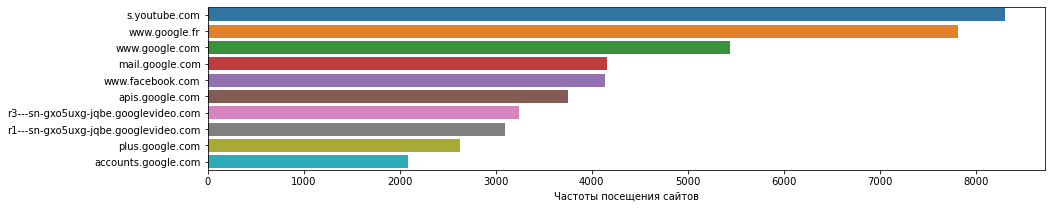

In [50]:
fig, ax = plt.subplots(figsize = (15, 3))
sns.barplot(x = top10_sites, y = top10_freqs, ax = ax)
ax.set_xlabel('Частоты посещения сайтов')

plt.show()

# Часть 3. Проверка построенных признаков

Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки session_timespan, #unique_sites, start_hour и day_of_week.

10. Выведите медианную продолжительность сессии (session_timespan) для сессий 10 пользователей.

In [51]:
np.median(train_data_10users['session_timespan'])

37.0

11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.

In [52]:
np.median(train_data_10users['day_of_week'])

2.0

12. Выведите медианный час начала сессии для сессий 150 пользователей.

In [53]:
np.median(train_data_150users['start_hour'])

13.0

13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.

In [54]:
np.median(train_data_150users['#unique_sites'])

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки.

На следующей неделе мы будем использовать "мешок" сайтов для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):

- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
...

Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами session_length=10 и window_size=10. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.

In [28]:
def feature_engineering(path_to_csv_files, site_freq_path, 
                        features, session_length=10, window_size=10):
    sessions_list = []
    with open(site_freq_path, 'rb') as f:
        freq_dict = pickle.load(f)
    top30_sites = list(site_freq_10users.keys())[:30]
    users_files = sorted(glob(os.path.join(path_to_csv_files, 'user[0-9][0-9][0-9][0-9].csv')))
    for user in tqdm_notebook(users_files):
        user_data = pd.read_csv(user)
        site_list = user_data.site.values
        timestamp_list = [pd.to_datetime(timestamp) for timestamp 
                          in user_data.timestamp.values]
        session = {}  # Current session
        for i in range(0, len(site_list), window_size):
            session['popular_sites'] = 0
            session['popular_sites_time'] = 0
            site_window = site_list[i: i + session_length]
            time_window = timestamp_list[i: i + session_length]
            for site in site_window:
                if site in top30_sites:
                    session['popular_sites'] += 1
                else:
                    continue
            for j, timestamp in enumerate(time_window[:-1]):
                if site_window[j] in top30_sites:
                    session['popular_sites_time'] += (time_window[j + 1] - timestamp).total_seconds()
                else:
                    continue
            session['target'] = int(user.strip('.csv')[-4:])
            sessions_list.append(session)
            session = {}
    dframe = pd.DataFrame(sessions_list, columns=features).fillna(0).astype(int)
    return dframe

In [29]:
new2_features_10users = feature_engineering(
        path_to_csv_files=os.path.join(PATH_TO_DATA, '10users'), 
        site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
        features=['popular_sites', 'popular_sites_time', 'target'], 
        session_length=10, window_size=10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
new2_features_150users = feature_engineering(
        path_to_csv_files=os.path.join(PATH_TO_DATA, '150users'), 
        site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
        features=['popular_sites', 'popular_sites_time', 'target'], 
        session_length=10, window_size=10)

  0%|          | 0/150 [00:00<?, ?it/s]

In [31]:
with open(os.path.join(PATH_TO_DATA, 
                       'new2_features_10users.pkl'), 'wb') as new2_features_10users_pkl:
    pickle.dump(new2_features_10users, new2_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new2_features_150users.pkl'), 'wb') as new2_features_150users_pkl:
    pickle.dump(new2_features_150users, new2_features_150users_pkl)

14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.

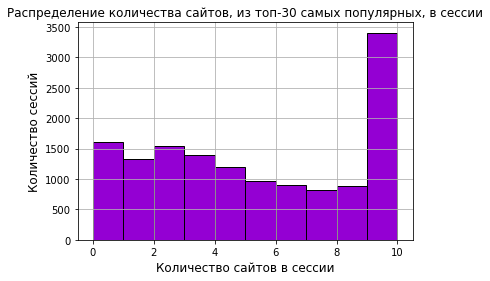

In [32]:
new2_features_10users['popular_sites'].hist(range=(0, 10), bins=10, 
                                           color='darkviolet', edgecolor='black')
plt.xlabel('Количество сайтов в сессии', fontsize='large')
plt.ylabel('Количество сессий', fontsize='large')
plt.title('Распределение количества сайтов, из топ-30 самых популярных, в сессии')
plt.show()

Гистограммы распределения количества сайтов, из топ-30 самых популярных, в сессии:


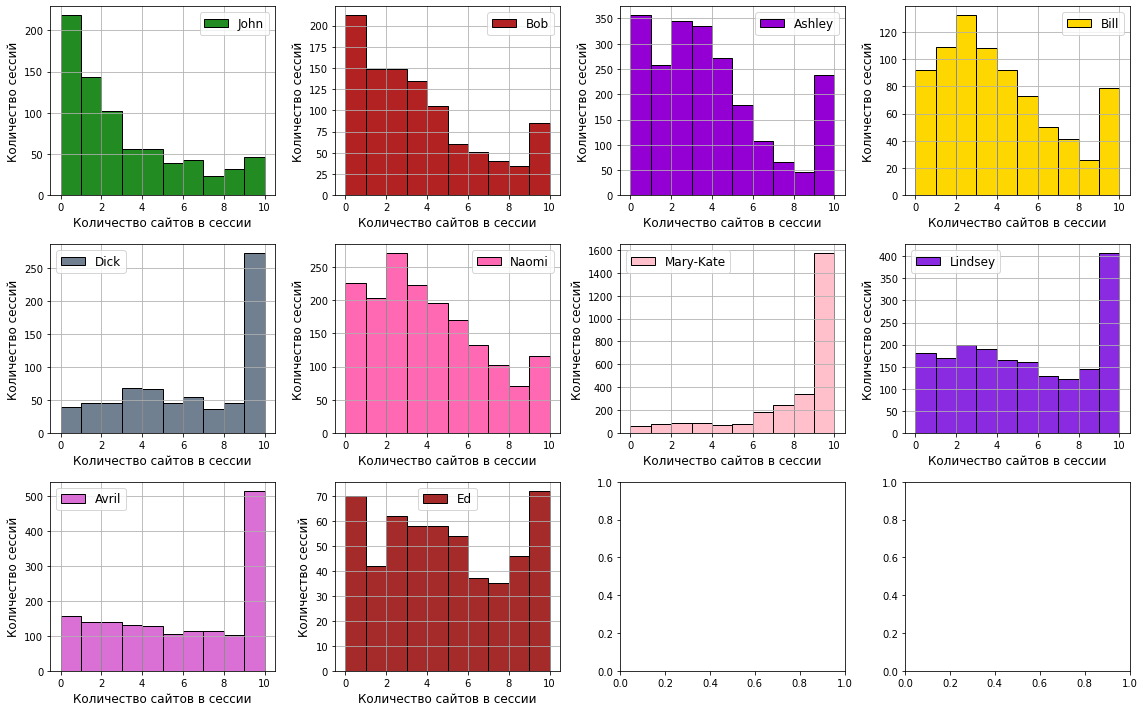

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
print('Гистограммы распределения количества сайтов, из топ-30 самых популярных, в сессии:')

for idx, (user, sub_df) in  enumerate(new2_features_10users.groupby('target')): 
    sub_df['popular_sites'].hist(color=color_dic[id_name_dict[user]], ax=axes[idx//4, idx%4], 
                               bins=10, range=(0, 10), edgecolor='black')
    axes[idx//4, idx%4].set_xlabel('Количество сайтов в сессии', fontsize='large')
    axes[idx//4, idx%4].set_ylabel('Количество сессий', fontsize='large')
    axes[idx//4, idx%4].legend([id_name_dict[user]], fontsize='large')
plt.tight_layout()

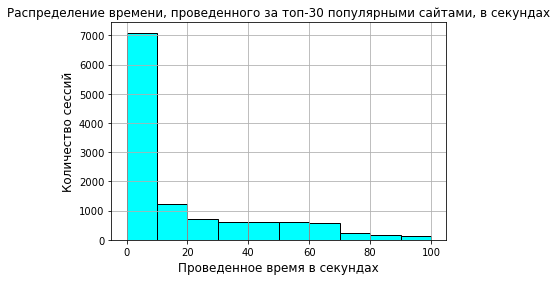

In [34]:
new2_features_10users['popular_sites_time'].hist(range=(0, 100), color='aqua', 
                                                edgecolor='black')
plt.xlabel('Проведенное время в секундах', fontsize='large')
plt.ylabel('Количество сессий', fontsize='large')
plt.title('Распределение времени, проведенного за топ-30 популярными сайтами, в секундах')
plt.show()

Гистограммы распределения времени, проведенного за топ-30 популярными сайтами, в секундах:


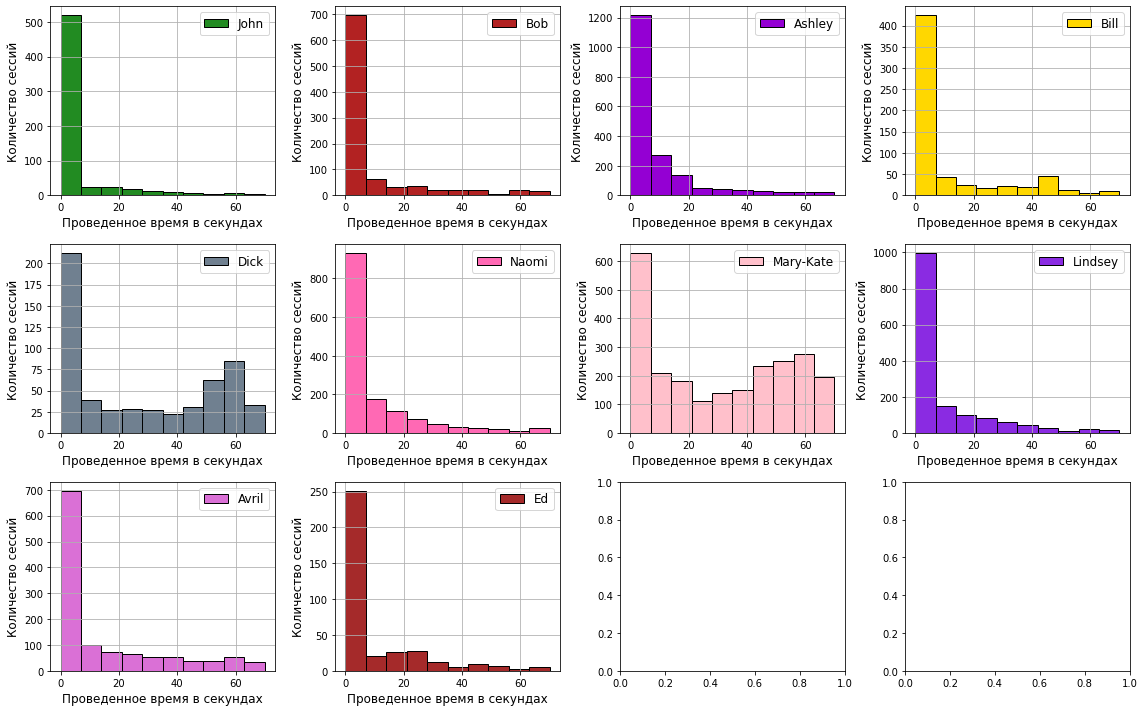

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
print('Гистограммы распределения времени, проведенного за топ-30 популярными сайтами, в секундах:')

for idx, (user, sub_df) in  enumerate(new2_features_10users.groupby('target')): 
    sub_df['popular_sites_time'].hist(range=(0, 70), color=color_dic[id_name_dict[user]], 
                                      ax=axes[idx//4, idx%4], edgecolor='black')
    axes[idx//4, idx%4].set_xlabel('Проведенное время в секундах', fontsize='large')
    axes[idx//4, idx%4].set_ylabel('Количество сессий', fontsize='large')
    axes[idx//4, idx%4].legend([id_name_dict[user]], fontsize='large')
plt.tight_layout()

Рассматривая графики распределения количества сайтов, из топ-30 самых популярных, в сессии, можно разделить пользователей на 3 группы:

1. пользователи, которые редко посещают популярные сайты;
2. пользователи, которые посещают как популярные, так и непопулярные сайты;
3. пользователи, которые посещают по большей части популярные сайты.
! Также, можно заметить, что к последней группе в основном относятся девушки.

По графикам распределения времени, проведенного за топ-30 популярными сайтами, можно сделать вывод, что пользователи в основном не тратят на них много времени. 
Однако из всего количества пользователей можно выделить двух, которые провели умеренное количество времени за популярными сайтами.

#### В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (session_timespan, #unique_sites, start_hour, day_of_week), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров session_length и window_size.

In [36]:
selected_features_10users = np.hstack((new_features_10users, 
                                      new2_features_10users[['popular_sites', 
                                                             'popular_sites_time']]))
selected_features_150users = np.hstack((new_features_150users, 
                                       new2_features_150users[['popular_sites', 
                                                               'popular_sites_time']]))

In [37]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

#### Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

#### Пути улучшения
7 неделя посвящена общему описанию проекта (html, ipynb или pdf) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:

- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – раз и два)
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE (только пользуйтесь эффективными реализациями типа Multicore-TSNE, не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации.